 # Transfer learning in InceptionV3 using Keras

## Loading Inception Network from Keras Applications

Keras includes Inception for academic and research purposes. Here we are downloading the model from Keras and showing a summary of it's various layers. InceptionV3 is one of the most advanced Deep Learning Networks in the public domain, and was trained by Google on multiple GPUs in a process spanning weeks. It has shown the highest performance recorded  for solving the Imagenet dataset. One more way to load Inception is to use code from Tensorflow's Github, however since it loads the entire network along with it's weights, training and test data, the download alone would take days or weeks on a standard computer. Therefore I decided to use the one from Keras (even this took a couple of hours and had to kept on overnight)

In [10]:
# example of loading the inception v3 model
from keras.applications.inception_v3 import InceptionV3
# load model
model = InceptionV3()
# summarize the model
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

This is just some random code that ensures if Tensorflow is installed and the GPU is active. Windows 10's security features mean that the function returns an empty string instead of the GPU. It could work more correctly once I have integrated the GPU into Jupyter's environment.

In [11]:
import tensorflow as tf
tf.test.gpu_device_name()

''

## Preparing the Dataset

Finding a good dataset to train a network as large as Inception is extremely important. It shouldn't be way to large or the model will overfit and learn features that it shouldn't have in the first place. Also the quality of data should be good enough. I tried downloading the Imagenet dataset however the download is restricted to people who have an organisational email address and is allowed only for academic purposes on a request basis. So because of that I couldn't download a specific human images dataset. I found this really cool Cats and Dogs dataset with over 12k photos. 

For preparing the dataset, I replaced the standard functions with a library that makes it super easy to split the folders. By using a seed, it becomes easier to reproduce the split.

In [24]:
import split_folders
split_folders.ratio('input', output="output", seed=1337, ratio=(.7, .3))

The code below doesn't work. I am just leaving it here because it defines a couple of variables essential for the remaining programs to run

In [15]:
Cat = glob('Cat/*.jpg')
Dog = glob('Dog/*.jpg')

cats_train, cats_test = train_test_split(Cat, test_size=0.30)
dogs_train, dogs_test = train_test_split(Dog, test_size=0.30)

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [16]:
TRAIN_DIR = 'train'
TEST_DIR = 'test'

In [17]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

cats = np.random.choice(cats_train, 13)
dogs = np.random.choice(dogs_train, 12)
data = np.concatenate((cats, dogs))
labels = 13 * ['Cat'] + 12 *['Dog']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

NameError: name 'cats_train' is not defined

In [18]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

CLASSES = 2
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 17498 images belonging to 2 classes.
Found 7502 images belonging to 2 classes.


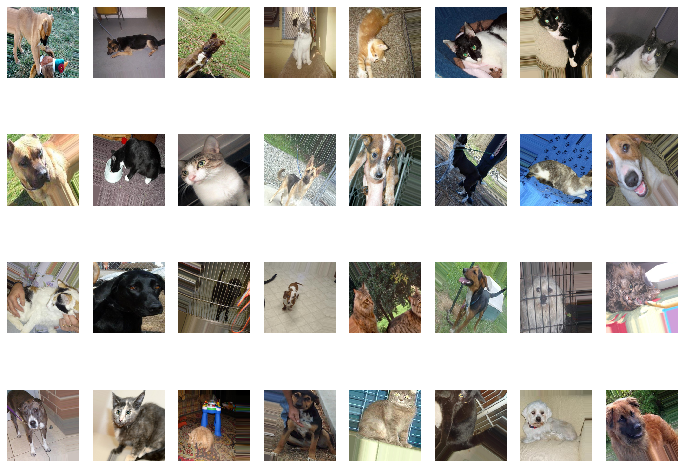

In [18]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [22]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'Inception.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/5
320/320 [==============================] - 1716s 5s/step - loss: 0.1637 - accuracy: 0.9347 - val_loss: 0.2671 - val_accuracy: 0.9585
Epoch 2/5
139/320 [============>.................] - ETA: 13:20 - loss: 0.1527 - accuracy: 0.9376

f:\env-py37\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
f:\env-py37\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
f:\env-py37\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
f:\env-py37\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
f:\env-py37\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s"

320/320 [==============================] - 1730s 5s/step - loss: 0.1523 - accuracy: 0.9394 - val_loss: 0.0531 - val_accuracy: 0.9536
Epoch 3/5
320/320 [==============================] - 1730s 5s/step - loss: 0.1400 - accuracy: 0.9456 - val_loss: 0.1014 - val_accuracy: 0.9507
Epoch 4/5
320/320 [==============================] - 1732s 5s/step - loss: 0.1368 - accuracy: 0.9500 - val_loss: 0.3285 - val_accuracy: 0.9300
Epoch 5/5
320/320 [==============================] - 1731s 5s/step - loss: 0.1485 - accuracy: 0.9422 - val_loss: 0.0404 - val_accuracy: 0.9595


In [1]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

NameError: name 'history' is not defined

array([9.9998868e-01, 1.1323225e-05], dtype=float32)

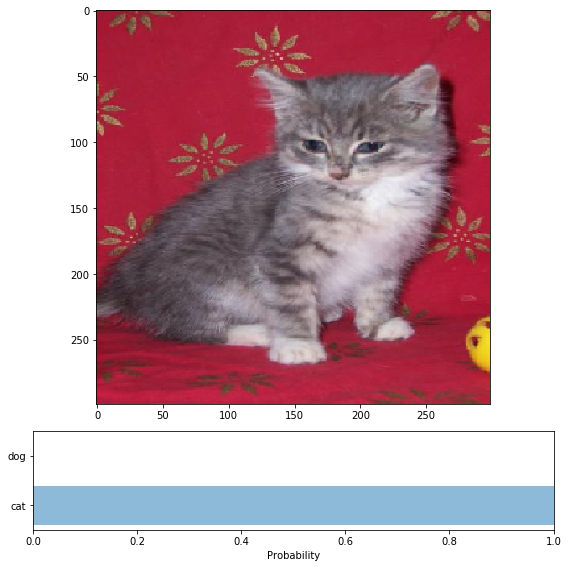

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model

MODEL_FILE = 'Inception.model'
HEIGHT = 299
WIDTH = 299

def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("cat", "dog")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()
    
model = load_model(MODEL_FILE)
    
img = image.load_img('test/Cat/110.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds